In [1]:
import pandas as pd
import numpy as np
import ipython_memory_usage.ipython_memory_usage as imu
#from describe_csv import *  # charge le fichier describe_csv.py par chunk de 10 000 (10**4)
#from ydata_profiling import ProfileReport
import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy as sp
import scipy.stats
from pivottablejs import pivot_ui
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

Objectif métier :
Améliorer la prise de décision stratégique (coaching, paris sportifs, fan engagement) en prédisant le vainqueur d’un match NBA.

Objectif analytique :
Développer un modèle de machine learning capable de prédire le gagnant d’un match NBA à partir de données historiques (matchs, joueurs, équipes, classement).

Problématique :
Nous cherchons à prédire le vainqueur d’un match NBA avant qu’il ait lieu, en utilisant des données historiques sur les matchs, équipes, classements et joueurs.

Sources & projets similaires :

NBA Winner Prediction sur Kaggle : https://www.kaggle.com/datasets/fivethirtyeight/nba-elo-dataset
Utilisation du classement ELO et du lieu du match comme features clés.

Predict NBA Games with ML (blog Medium) :
Utilise des modèles comme XGBoost avec des features comme l’historique des confrontations et l’écart de points moyen.

Sports Analytics Conference Papers (MIT Sloan) :
Donnent des insights sur les métriques influentes (net rating, true shooting %, pace...).

Les modèles les plus souvent utilisés sont :
- la Random Forest qui est un bon compromis entre performance et interprétabilité, robuste aux features bruites; 
- le XGBoost qui est un excellent modèle pour les datasets structurés comme celui-ci, il gère bien les non-linéarités et interactions entre les variables;
- la régression linéaire basique et interprétable facilement.

Nous choisirons alors la Random Forest pour sa robustesse que nous comparerons au XGBoost.

Contraintes/ Limites :

Données manquantes ou bruitées (blessures, transferts non représentés).

Évolution des équipes dans le temps (changement d’effectifs, performance).

Tâche déséquilibrée si certaines équipes gagnent très souvent.

Dépendance temporelle : attention à ne pas entraîner sur des matchs plus récents que ceux du test (fuite de données).

Variables non disponibles en amont du match (ex. stats détaillées des joueurs d’un match à prédire).



In [3]:
# chargement des données :)


games = pd.read_csv("data/games.csv")
games_details = pd.read_csv("data/games_details.csv")
players = pd.read_csv("data/players.csv")
ranking = pd.read_csv("data/ranking.csv")
teams = pd.read_csv("data/teams.csv")

C:\Users\Maxime\AppData\Local\Temp\ipykernel_24852\2549305382.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  games_details = pd.read_csv("data/games_details.csv")


In [4]:
for df, name in zip([games, games_details, players, ranking, teams], 
                    ['games', 'games_details', 'players', 'ranking', 'teams']):
    print(f"{name}: {df.shape}")
    print(df.dtypes)
    print(df.isnull().sum(), "\n")


games: (26651, 21)
GAME_DATE_EST        object
GAME_ID               int64
GAME_STATUS_TEXT     object
HOME_TEAM_ID          int64
VISITOR_TEAM_ID       int64
SEASON                int64
TEAM_ID_home          int64
PTS_home            float64
FG_PCT_home         float64
FT_PCT_home         float64
FG3_PCT_home        float64
AST_home            float64
REB_home            float64
TEAM_ID_away          int64
PTS_away            float64
FG_PCT_away         float64
FT_PCT_away         float64
FG3_PCT_away        float64
AST_away            float64
REB_away            float64
HOME_TEAM_WINS        int64
dtype: object
GAME_DATE_EST        0
GAME_ID              0
GAME_STATUS_TEXT     0
HOME_TEAM_ID         0
VISITOR_TEAM_ID      0
SEASON               0
TEAM_ID_home         0
PTS_home            99
FG_PCT_home         99
FT_PCT_home         99
FG3_PCT_home        99
AST_home            99
REB_home            99
TEAM_ID_away         0
PTS_away            99
FG_PCT_away         99
FT_PCT_away

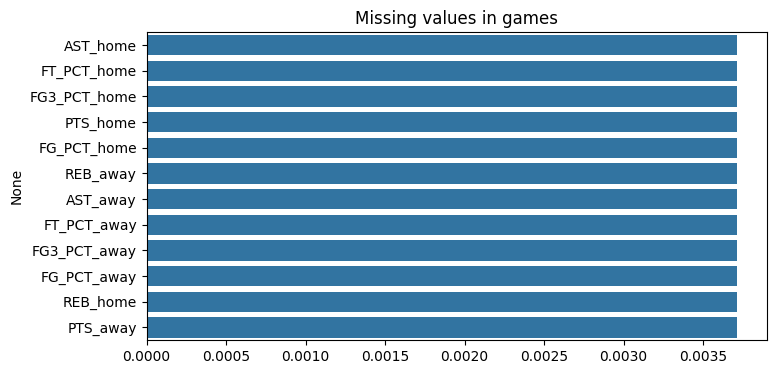

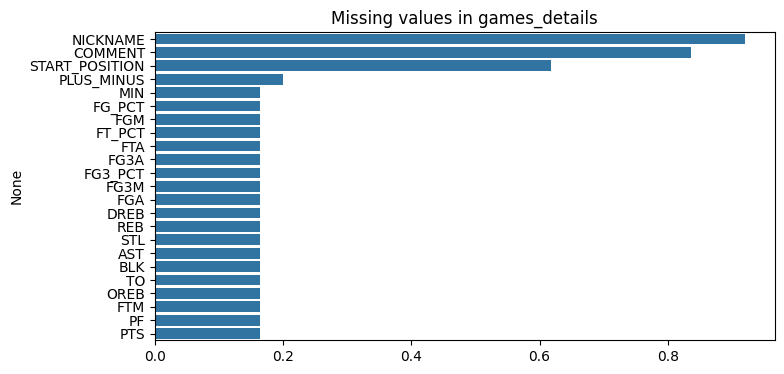

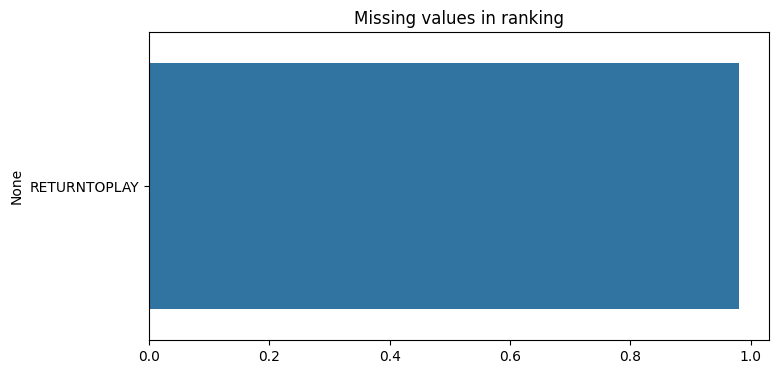

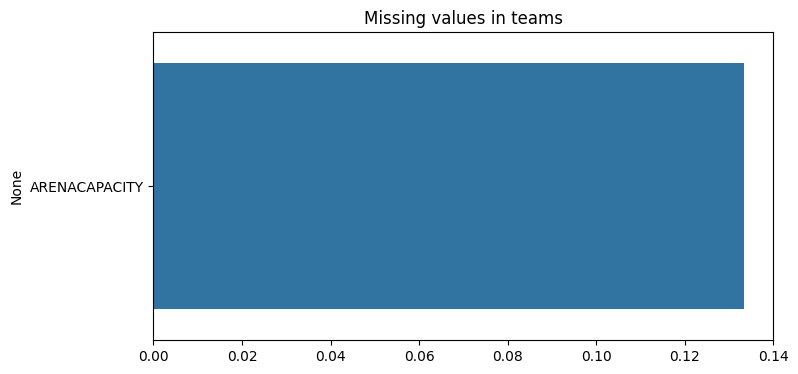

In [5]:
# Traitement des données manquantes 


def plot_missing(df, name):
    missing = df.isnull().mean().sort_values(ascending=False)
    missing = missing[missing > 0]
    if not missing.empty:
        plt.figure(figsize=(8,4))
        sns.barplot(x=missing.values, y=missing.index)
        plt.title(f"Missing values in {name}")
        plt.show()

for df, name in zip([games, games_details, players, ranking, teams], 
                    ['games', 'games_details', 'players', 'ranking', 'teams']):
    plot_missing(df, name)

In [ ]:
# pour games.csv :
# peu de valeurs manquantes dans PTS_home et PTS_away, on peut supprimer les valeurs manquantes sans craindre un impact significatif sur le jeu de données 

games.dropna(subset=['PTS_home', 'PTS_away'], inplace=True)

# pour games_details.csv :
# beaucoup de données manquantes à cause des joueurs n'ayant pas joué dans games_details.csv on les remplace par des 0

games_details.fillna(0, inplace=True)

# les colonnes COMMENT et NICKNAME ne seront pas utiles dutout pour le modèle on peut les supprimer

games_details.drop(columns=['COMMENT','NICKNAME'], inplace=True)

# pour ranking.csv : 
# la colonne RETURNTOPLAY est manquant partout, on peut donc la supprimer

ranking.drop(columns=['RETURNTOPLAY'], inplace=True)

# pour teams.csv :
# ARENACAPACITY est partiellement manquant, mais clairement pas utile pour la prédiction donc on peut la supprimer aussi 

teams.drop(columns=['ARENACAPACITY'], inplace=True)

## EDA 

L’analyse exploratoire des données (EDA) constitue une étape essentielle dans tout projet de machine learning. Dans le cadre de ce TP, qui vise à prédire les vainqueurs de matchs NBA, l’EDA permet d'établir une première compréhension approfondie des données à disposition, avant même d’envisager la modélisation. Elle nous aide à mieux saisir la structure, les relations et les dynamiques sous-jacentes aux différents jeux de données.

Concrètement, cette phase exploratoire va nous permettre d’identifier les premières tendances clés du jeu, comme par exemple la fréquence des victoires à domicile, l’impact du classement sur l’issue d’un match, ou encore le lien entre certaines statistiques collectives ou individuelles et le résultat final. En observant la distribution des scores, des écarts de points ou encore des performances individuelles, nous serons en mesure de formuler des hypothèses solides sur les facteurs prédictifs les plus influents.

L’EDA nous permettra également de repérer d’éventuelles anomalies dans les données, comme des valeurs extrêmes ou manquantes, qui pourraient fausser l’apprentissage du modèle. Elle jouera aussi un rôle clé dans la compréhension temporelle des données : certaines équipes évoluent, les effectifs changent, et les dynamiques saisonnières peuvent fortement influencer les résultats. Ces éléments devront être pris en compte dans la phase de modélisation.

Enfin, cette étape servira à orienter intelligemment la construction des futures variables explicatives. En comprenant ce qui différencie statistiquement une victoire d’une défaite, nous pourrons créer des features plus pertinentes et donc finalement entraîner un modèle plus performant.

Avant d’aborder la modélisation, il est fondamental d’explorer les données afin d’identifier les tendances générales, les déséquilibres éventuels et les éléments susceptibles d'influencer l'issue d’un match. Dans le cadre de ce TP, notre objectif est de prédire le vainqueur d’un match NBA. L’analyse exploratoire va donc nous aider à comprendre quelles variables semblent associées à la victoire et à quelle fréquence certains phénomènes se produisent, comme l’avantage du terrain ou les performances individuelles déterminantes.

Pour commencer, nous allons nous intéresser à la répartition des matchs dans le temps, ainsi qu'à l'avantage éventuel de jouer à domicile. Cela permettra de dresser un premier portrait de la structure des données et de leur contenu sportif.

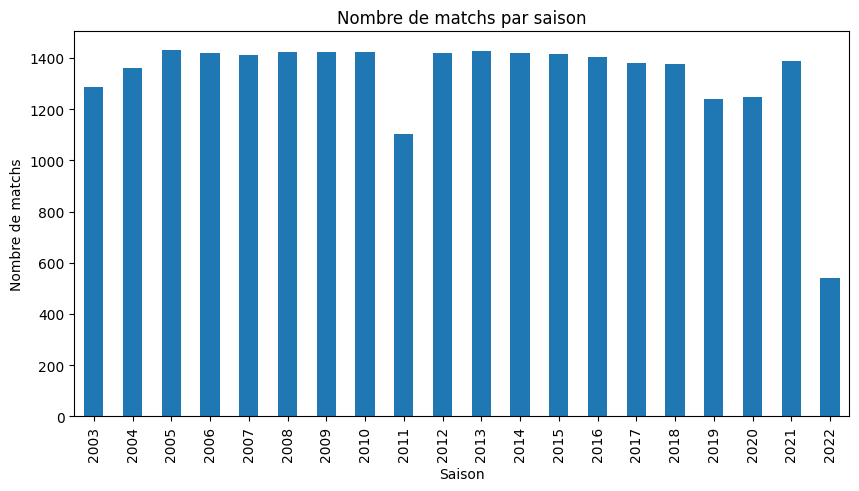

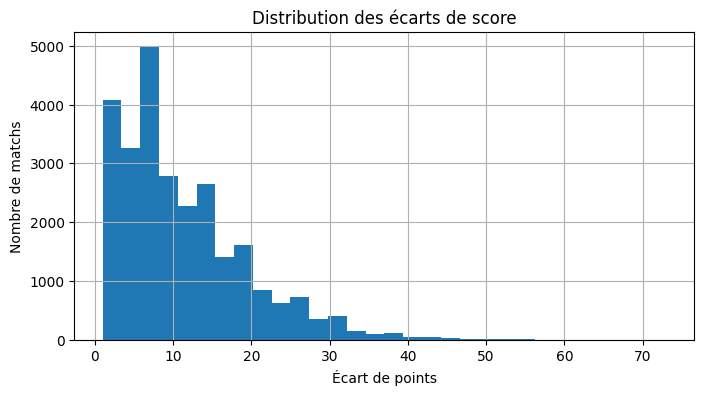

Taux de victoire à domicile : 58.92%


In [9]:
# nombre de matchs par saison
games['SEASON'].value_counts().sort_index().plot(kind='bar', figsize=(10,5), title="Nombre de matchs par saison")
plt.xlabel("Saison")
plt.ylabel("Nombre de matchs")
plt.show()

# répartition des écarts de score
games['score_diff'] = abs(games['PTS_home'] - games['PTS_away'])
games['score_diff'].hist(bins=30, figsize=(8,4))
plt.title("Distribution des écarts de score")
plt.xlabel("Écart de points")
plt.ylabel("Nombre de matchs")
plt.show()

# taux de victoire à domicile
home_win_rate = (games['PTS_home'] > games['PTS_away']).mean()
print(f"Taux de victoire à domicile : {home_win_rate:.2%}")

La première visualisation montre une répartition relativement stable du nombre de matchs par saison, avec quelques baisses notables. Ces baisses peuvent probablement s’expliquer par des événements exceptionnels comme les lockouts NBA (ex. 2011) ou la pandémie de COVID-19 (ex. 2020 et 2022). Ce type d’information est important à garder en tête pour l’interprétation des performances des équipes sur ces saisons plus courtes.

La seconde visualisation met en évidence la distribution des écarts de score. On constate que la grande majorité des matchs se jouent avec moins de 15 points d’écart, ce qui souligne le caractère souvent serré des rencontres NBA. Il est néanmoins intéressant de noter que certains matchs atteignent des écarts bien plus larges, ce qui pourrait signaler des déséquilibres ponctuels liés à la composition des équipes ou au contexte du match, mais c'est bien plus rare.

Le taux de victoire à domicile de 58,92 % est une information précieuse, car il confirme l’existence d’un avantage du terrain, bien connu en NBA. Ce biais structurel pourra être exploité comme une feature explicative importante lors de la phase de modélisation. Il faudra donc conserver l’information sur l’équipe qui joue à domicile dans la construction des features.

#### Les équipes

L’objectif ici est d’étudier la performance des équipes sur l’ensemble des saisons disponibles. Cela nous permettra de repérer les franchises les plus dominantes, mais aussi d’observer si le niveau d’une équipe reste constant dans le temps ou non. On s’intéressera notamment à la moyenne de points marqués à domicile et à l’extérieur, ainsi qu’à leur régularité.

In [13]:
# moyenne de points marqués par les équipes à domicile
pts_home_avg = games.groupby('HOME_TEAM_ID')['PTS_home'].mean().sort_values(ascending=False)

# moyenne de points encaissés à domicile (par les visiteurs)
pts_conceded_home = games.groupby('HOME_TEAM_ID')['PTS_away'].mean().sort_values(ascending=False)

# moyenne de points marqués à l'extérieur
pts_away_avg = games.groupby('VISITOR_TEAM_ID')['PTS_away'].mean().sort_values(ascending=False)

# moyenne de points encaissés à l'extérieur (par les locaux)
pts_conceded_away = games.groupby('VISITOR_TEAM_ID')['PTS_home'].mean().sort_values(ascending=False)


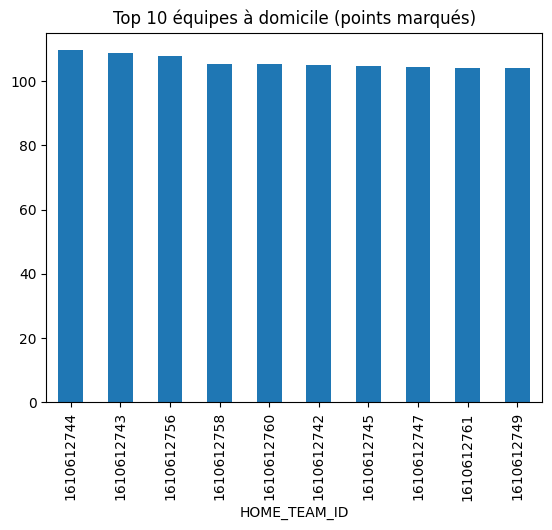

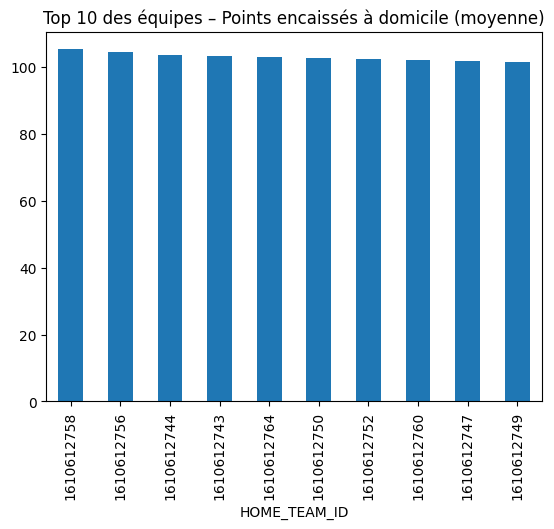

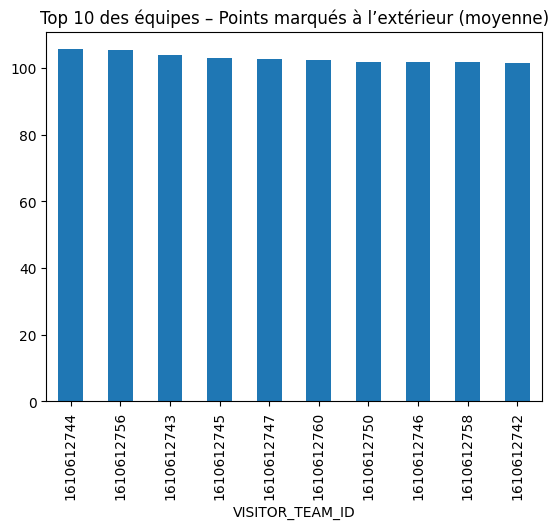

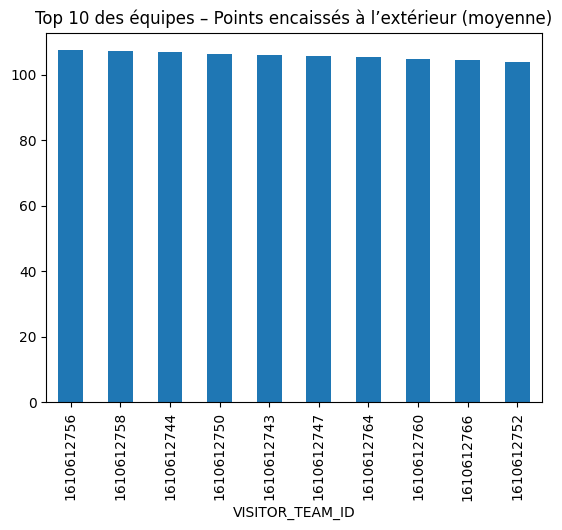

In [16]:
pts_home_avg.head(10).plot(kind='bar', title="Top 10 équipes à domicile (points marqués)")
plt.show()

pts_conceded_home.head(10).plot(kind='bar', title="Top 10 des équipes – Points encaissés à domicile (moyenne)")
plt.show()

pts_away_avg.head(10).plot(kind='bar', title="Top 10 des équipes – Points marqués à l’extérieur (moyenne)")
plt.show()

pts_conceded_away.head(10).plot(kind='bar', title="Top 10 des équipes – Points encaissés à l’extérieur (moyenne)")
plt.show()


Ces visualisations confirment plusieurs tendances intéressantes. 
On observe d’abord que certaines équipes se distinguent régulièrement par leur capacité à marquer un grand nombre de points, aussi bien à domicile qu’à l’extérieur. Cela peut refléter une force offensive stable sur plusieurs saisons. De la même manière, les moyennes de points encaissés mettent en lumière les équipes les plus perméables défensivement, ce qui peut avoir un impact direct sur leurs chances de victoire.

Cependant, les identifiants des équipes (comme "1610612744") ne sont pas très lisibles tels quels. Il serait donc pertinent de les lier avec le fichier teams.csv, afin d’afficher les noms d’équipes dans les graphiques. Cela rendra l’interprétation beaucoup plus claire et permettra de tirer des conclusions concrètes sur les franchises.

##### jointure des tables :

In [17]:
# dictionnaire des noms de teams
team_names = teams.set_index('TEAM_ID')['NICKNAME'].to_dict()

In [18]:
# remplacement des index par les noms d’équipes
pts_home_avg_named = pts_home_avg.rename(index=team_names)
pts_conceded_home_named = pts_conceded_home.rename(index=team_names)
pts_away_avg_named = pts_away_avg.rename(index=team_names)
pts_conceded_away_named = pts_conceded_away.rename(index=team_names)


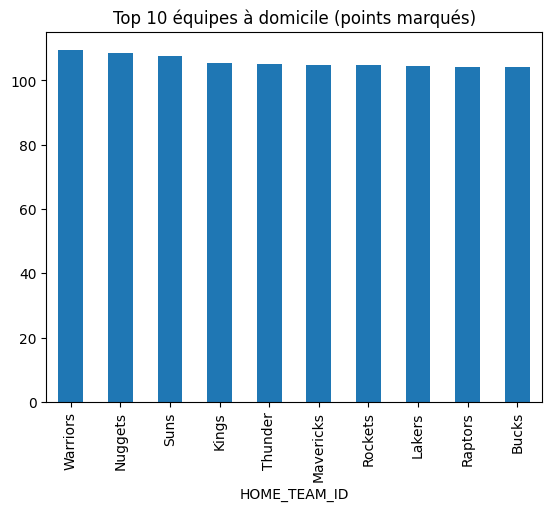

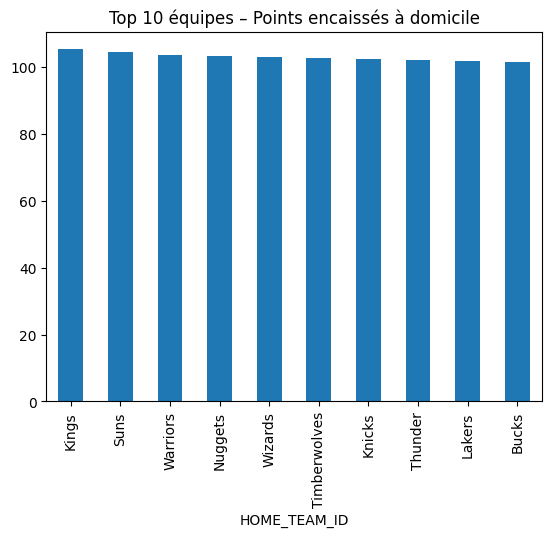

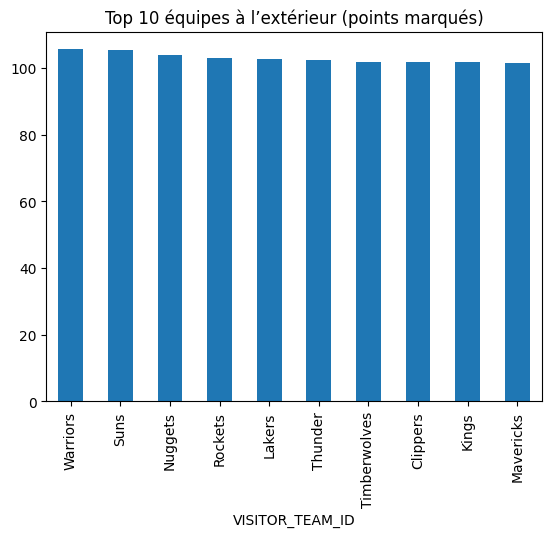

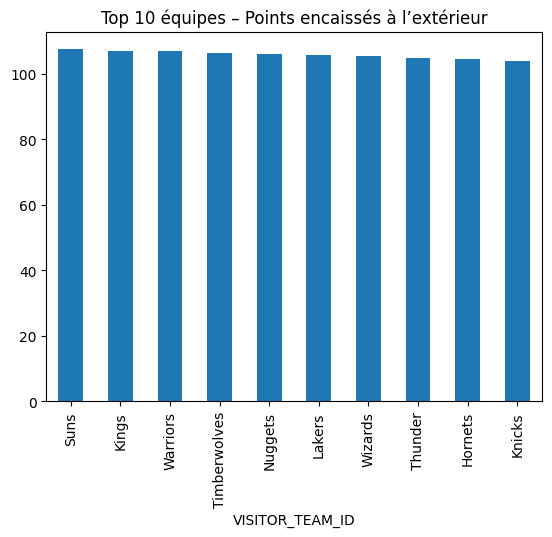

In [19]:
# maintenant nous pouvons revérifier les résultats précédents :

pts_home_avg_named.head(10).plot(kind='bar', title="Top 10 équipes à domicile (points marqués)")
plt.show()

pts_conceded_home_named.head(10).plot(kind='bar', title="Top 10 équipes – Points encaissés à domicile")
plt.show()

pts_away_avg_named.head(10).plot(kind='bar', title="Top 10 équipes à l’extérieur (points marqués)")
plt.show()

pts_conceded_away_named.head(10).plot(kind='bar', title="Top 10 équipes – Points encaissés à l’extérieur")
plt.show()

On observe que les Warriors, les Nuggets et les Suns sont parmi les équipes qui marquent le plus, que ce soit à domicile ou à l’extérieur, ce qui souligne leur potentiel offensif constant. Les Kings apparaissent comme une équipe à la fois productive et vulnérable : ils marquent beaucoup à domicile mais figurent aussi parmi celles qui encaissent le plus, ce qui pourrait indiquer un style de jeu très ouvert.

De leur côté, les Timberwolves, Knicks ou Hornets se démarquent dans les classements défensifs à l’extérieur, ce qui peut en faire des adversaires difficiles à affronter loin de leurs bases. Les Lakers, Thunder et Wizards sont présents dans plusieurs catégories, ce qui reflète une certaine constance, qu’elle soit offensive ou défensive.

### Les classements

Pour poursuivre notre EDA, nous allons maintenant explorer dans quelle mesure les performances statistiques des équipes (comme les points marqués) se traduisent en victoires réelles, telles que reflétées dans les classements. Cela nous permettra de valider ou non l'idée selon laquelle les équipes les plus offensives ou les plus solides défensivement sont aussi celles qui gagnent le plus de matchs.

Nous allons nous intéresser à la proportion de victoires (W_PCT), en moyenne par équipe.

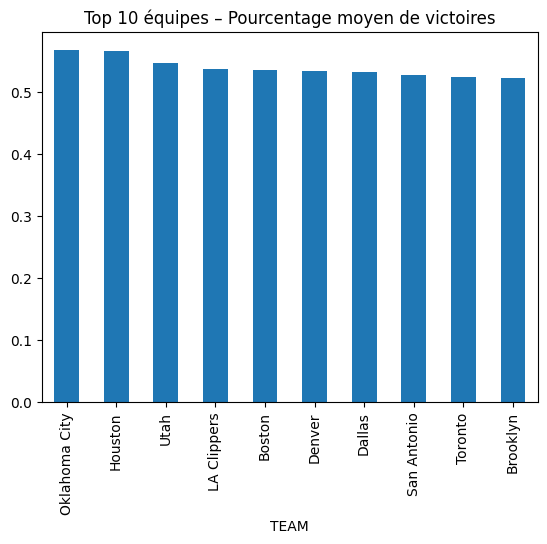

In [20]:
# on convertit la date pour ne garder qu'une ligne par saison et par équipe (la dernière en date)
ranking['STANDINGSDATE'] = pd.to_datetime(ranking['STANDINGSDATE'])
ranking_latest = ranking.sort_values('STANDINGSDATE').drop_duplicates(
    subset=['TEAM_ID', 'SEASON_ID'], keep='last')

# moyenne de victoire sur l'ensemble des saisons
win_pct_avg = ranking_latest.groupby('TEAM')['W_PCT'].mean().sort_values(ascending=False)

win_pct_avg.head(10).plot(kind='bar', title="Top 10 équipes – Pourcentage moyen de victoires")
plt.show()

Ce graphique met en évidence les dix équipes ayant obtenu les meilleurs pourcentages moyens de victoire sur l’ensemble des saisons. On y retrouve notamment Oklahoma City, Houston, Utah et les Clippers, ce qui confirme leur régularité dans les performances, du moins sur la période analysée.

Ce classement est intéressant à croiser avec les observations précédentes. Par exemple, Oklahoma City n’apparaissait pas systématiquement parmi les meilleures équipes en termes de points marqués ou encaissés, ce qui suggère qu’elle pourrait compenser par une gestion efficace des fins de match, un bon ratio victoires/défaites dans les matchs serrés, ou un équilibre général. À l’inverse, certaines équipes très offensives comme Golden State ne figurent pas dans ce top 10, ce qui pourrait s’expliquer par des périodes de creux dans certaines saisons.

Ces résultats soulignent une chose essentielle pour le futur modèle prédictif : les performances brutes (points marqués) ne suffisent pas à prédire la victoire.

Nous allons maintenant mesurer la corrélation entre les stats de match (comme les points marqués) et le % de victoires (W_PCT) pour identifier les variables prédictives fortes :

In [ ]:
# moyennes par équipe (toutes saisons confondues)
team_stats = pd.DataFrame({
    'PTS_home_avg': games.groupby('HOME_TEAM_ID')['PTS_home'].mean(),
    'PTS_away_avg': games.groupby('VISITOR_TEAM_ID')['PTS_away'].mean(),
    'PTS_conceded_home': games.groupby('HOME_TEAM_ID')['PTS_away'].mean(),
    'PTS_conceded_away': games.groupby('VISITOR_TEAM_ID')['PTS_home'].mean()
})
team_stats['TEAM_ID'] = team_stats.index

In [22]:
# jointure avec ranking pour W_PCT moyen

# moyenne W_PCT par équipe sur toutes les saisons
ranking_avg = ranking_latest.groupby('TEAM_ID')['W_PCT'].mean().reset_index()

# fusion
merged = pd.merge(team_stats, ranking_avg, on='TEAM_ID')

In [23]:
# calcul de corrélations
correlations = merged.corr(numeric_only=True)['W_PCT'].drop('W_PCT')
print(correlations.sort_values(ascending=False))

PTS_away_avg         0.422487
PTS_home_avg         0.380263
PTS_conceded_away   -0.207062
PTS_conceded_home   -0.254324
TEAM_ID             -0.271605
Name: W_PCT, dtype: float64


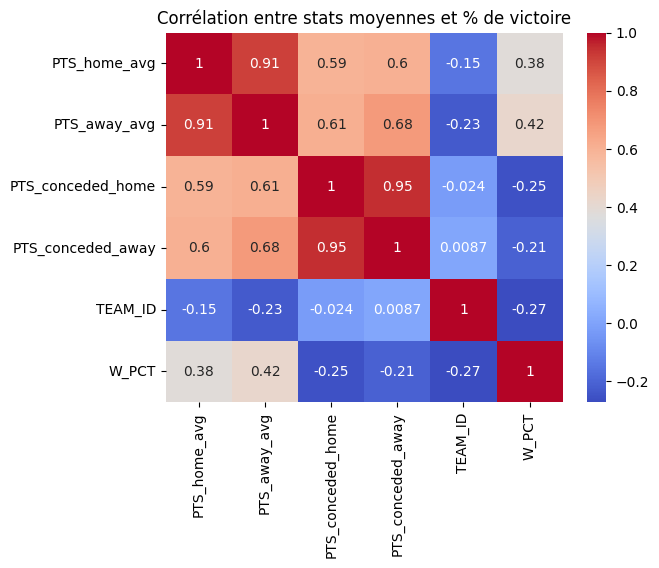

In [24]:
# visu heatmap

sns.heatmap(merged.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Corrélation entre stats moyennes et % de victoire")
plt.show()

On observe que les variables les plus corrélées positivement avec le pourcentage de victoires sont la moyenne de points marqués à l’extérieur (PTS_away_avg) et à domicile (PTS_home_avg). Cela confirme l’intuition selon laquelle une équipe qui marque beaucoup a plus de chances de gagner. Néanmoins, les corrélations restent modérées (~0.42), ce qui montre qu’il ne suffit pas de bien scorer pour dominer : d'autres facteurs entrent en jeu.

À l’inverse, les points encaissés (PTS_conceded_home et PTS_conceded_away) sont négativement corrélés avec le taux de victoire, ce qui est cohérent : plus une équipe concède de points, moins elle gagne. Cela dit, les corrélations sont légèrement plus faibles que pour l’attaque, ce qui pourrait suggérer que l’efficacité offensive est un levier plus différenciant dans cette ligue que la défense seule.

Enfin, la colonne TEAM_ID montre une corrélation négative sans signification réelle : c’est un identifiant sans portée explicative, donc à exclure du modèle.

Ces résultats orientent clairement la sélection de features : les moyennes de points marqués et encaissés, différenciées par lieu, seront des indicateurs pertinents à inclure dans ton modèle prédictif. On pourra ensuite enrichir avec d'autres dimensions (dynamique temporelle, forme récente, classement, etc.).

#### Exploration des performances indviduelles par joueur

L'idée est d’explorer les performances individuelles : quels joueurs marquent le plus, quelles sont les stats les plus différenciantes, et dans quelle mesure certaines performances (comme les points, le temps de jeu ou le +/-) sont associées à la victoire de leur équipe.

In [25]:
# jointure des infos des joueurs à leur performance par match :

# fusion des stats de match avec les infos de players.csv
players_details = pd.merge(games_details, players[['PLAYER_ID', 'SEASON']], on='PLAYER_ID', how='left')


Joueurs qui marquent le plus de points en moyenne :

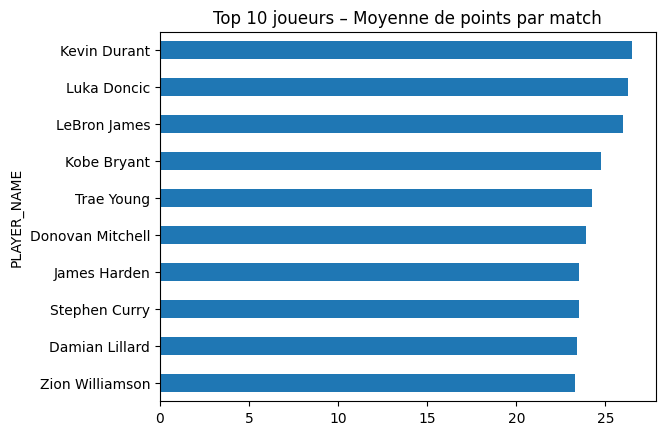

In [26]:
top_scorers = games_details.groupby('PLAYER_NAME')['PTS'].mean().sort_values(ascending=False).head(10)
top_scorers.plot(kind='barh', title="Top 10 joueurs – Moyenne de points par match")
plt.gca().invert_yaxis()
plt.show()

Ce graphique met en lumière les joueurs les plus prolifiques offensivement. On retrouve sans surprise des superstars comme Kevin Durant, Luka Doncic, LeBron James ou Stephen Curry. Ces joueurs ont un impact direct sur le score de leur équipe.

Joueurs ayant le plus de minutes jouées :

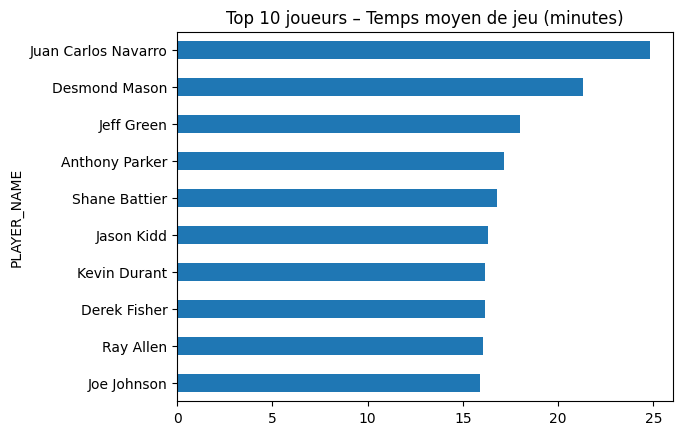

In [34]:
# tri rapide pour éviter du bruit dans des joueurs qui ne jouent pas activement
nb_games = games_details['PLAYER_NAME'].value_counts()
valid_players = nb_games[nb_games > 30].index  # seuil arbitraire de 30 matchs minimum

filtered_details = games_details[games_details['PLAYER_NAME'].isin(valid_players)]

top_minutes = filtered_details.groupby('PLAYER_NAME')['MIN'].mean().sort_values(ascending=False).head(10)
top_minutes.plot(kind='barh', title="Top 10 joueurs – Temps moyen de jeu (minutes)")
plt.gca().invert_yaxis()
plt.show()

Ici on obtient un top réaliste avec des joueurs connus ayant eu une vraie longévité en NBA comme Kevin Durant, Ray Allen, Joe Johnson ou Jason Kidd. Ce sont des profils fiables et actifs sur plusieurs saisons, ce qui donne beaucoup plus de sens aux moyennes calculées.

Joueurs avec le meilleur +/- :

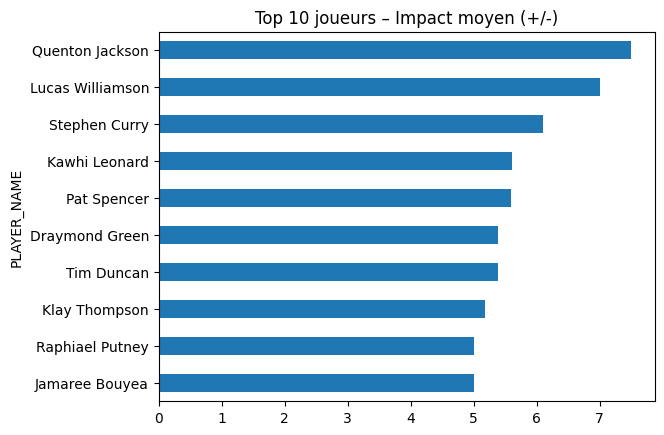

In [30]:
top_plus_minus = games_details.groupby('PLAYER_NAME')['PLUS_MINUS'].mean().sort_values(ascending=False).head(10)
top_plus_minus.plot(kind='barh', title="Top 10 joueurs – Impact moyen (+/-)")
plt.gca().invert_yaxis()
plt.show()

On retrouve sur ce graphique des joueurs majeurs comme Stephen Curry, Kawhi Leonard, Draymond Green ou Klay Thompson, qui appartiennent à des équipes réputées pour leur efficacité collective. Le PLUS_MINUS est donc une variable très intéressante pour capter l’impact d’un joueur sur la dynamique d’un match, au-delà des simples points marqués.

### Préparation des features du modèle

Nous avons structuré nos variables explicatives autour de trois grands axes : les caractéristiques contextuelles du match, les performances agrégées des équipes, et enfin, l’impact individuel des joueurs. L’objectif est de combiner des éléments structurels, historiques et dynamiques pour offrir au modèle une vision équilibrée de chaque rencontre.

Nous avons tout d’abord extrait les variables structurelles contenues dans le fichier games.csv, telles que les identifiants des équipes à domicile et à l’extérieur, la saison ou encore la date du match. Ces variables servent de base pour enrichir chaque ligne du jeu de données avec des statistiques calculées en amont, tout en veillant à ne jamais introduire d’informations indisponibles à la date du match. Par exemple, les performances passées des équipes ont été calculées sans inclure le match en question, afin d’éviter toute fuite de données temporelle.

Ensuite, nous avons intégré des statistiques agrégées par équipe, obtenues à partir de l’historique des matchs. Pour chaque équipe, nous avons calculé la moyenne de points marqués à domicile et à l’extérieur, ainsi que la moyenne de points encaissés selon le lieu du match. Ces indicateurs sont essentiels pour refléter à la fois la puissance offensive et la solidité défensive d’une équipe dans des contextes différents. En complément, nous avons incorporé le pourcentage moyen de victoires (W_PCT) issu des classements disponibles dans le fichier ranking.csv, ce qui nous permet de résumer en une seule variable la dynamique globale d’une équipe sur plusieurs saisons. L’analyse des corrélations a confirmé l’intérêt de ces variables, notamment la moyenne de points marqués, qui présente une relation modérée mais significative avec le taux de victoire.

Enfin, pour capturer l’impact des performances individuelles, nous avons exploité les données détaillées disponibles dans games_details.csv. Pour chaque match, nous avons agrégé les statistiques des cinq joueurs titulaires de chaque équipe afin d’obtenir des indicateurs représentatifs du niveau de jeu effectif. Parmi ces indicateurs, on retrouve la somme des points marqués par les titulaires, la moyenne du plus/minus qui mesure l’influence du joueur sur le différentiel de score lorsqu’il est sur le terrain, ainsi que le temps total de jeu cumulé. Ces variables apportent une granularité précieuse à notre approche, car elles permettent d’intégrer l’état de forme du cinq majeur, élément central dans l’issue d’un match NBA. Ainsi, une équipe dont les titulaires jouent beaucoup, marquent davantage et affichent un plus/minus positif aura statistiquement plus de chances de l’emporter.

Ainsi, notre stratégie de construction des features repose sur un équilibre entre des variables collectives (niveau global des équipes), des éléments contextuels (données propres au match), et des indicateurs individuels (performance des joueurs).